<a href="https://colab.research.google.com/github/Rajadhurairajendhiran123/textgrad_prompt_tune/blob/main/textgrad_prompt_tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install textgrad

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.4/360.4 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.4 MB/s eta 0:00:00
   ━

In [ ]:
import os
import concurrent.futures
from dotenv import load_dotenv
from tqdm import tqdm
import textgrad as tg
from textgrad.tasks import load_task
import numpy as np
import random

# Set your OpenAI API key if required
os.environ['OPENAI_API_KEY'] ='your api key '


# Helper function to set a random seed for reproducibility
def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)

def eval_sample(item, eval_fn, model):
    x, y = item
    x = tg.Variable(x, requires_grad=False, role_description="query to the language model")
    y = tg.Variable(str(y), requires_grad=False, role_description="correct answer for the query")
    response = model(x)
    try:
        eval_output_variable = eval_fn(inputs=dict(prediction=response, ground_truth_answer=y))
        return int(eval_output_variable.value)
    except:
        eval_output_variable = eval_fn([x, y, response])
        eval_output_parsed = eval_fn.parse_output(eval_output_variable)
        return int(eval_output_parsed)


# Function to evaluate an entire dataset
def eval_dataset(test_set, eval_fn, model, max_samples: int = None):
    if max_samples is None:
        max_samples = len(test_set)
    accuracy_list = []
    with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
        futures = []
        for i, sample in enumerate(test_set):
            future = executor.submit(eval_sample, sample, eval_fn, model)
            futures.append(future)
            if len(futures) >= max_samples:
                break
        tqdm_loader = tqdm(concurrent.futures.as_completed(futures), total=len(futures), position=0)
        for future in tqdm_loader:
            acc_item = future.result()
            accuracy_list.append(acc_item)
            tqdm_loader.set_description(f"Accuracy: {np.mean(accuracy_list)}")
    return accuracy_list

# Function to validate and revert the prompt if performance decreases
def run_validation_revert(system_prompt, results, model, eval_fn, val_set):
    val_performance = np.mean(eval_dataset(val_set, eval_fn, model))
    previous_performance = np.mean(results["validation_acc"][-1])
    print("val_performance: ", val_performance)
    print("previous_performance: ", previous_performance)
    previous_prompt = results["prompt"][-1]

    if val_performance < previous_performance:
        print(f"rejected prompt: {system_prompt.value}")
        system_prompt.set_value(previous_prompt)
        val_performance = previous_performance

    results["validation_acc"].append(val_performance)

# Set random seed for reproducibility
set_seed(12)

# Initialize language model engines
llm_api_eval = tg.get_engine(engine_name="gpt-4")
llm_api_test = tg.get_engine(engine_name="gpt-3.5-turbo")

# Load a dataset and evaluation function (using BBH_object_counting task)
train_set, val_set, test_set, eval_fn = load_task("BBH_object_counting", evaluation_api=llm_api_eval)

# Print dataset lengths
print("Train/Val/Test Set Lengths: ", len(train_set), len(val_set), len(test_set))

# Start with a basic system prompt
STARTING_SYSTEM_PROMPT = train_set.get_task_description()

# Create a system prompt variable
system_prompt = tg.Variable(STARTING_SYSTEM_PROMPT, requires_grad=True, role_description="system prompt to the language model")

# Initialize the model with the system prompt
model = tg.BlackboxLLM(llm_api_test, system_prompt)

# Optimizer setup
optimizer = tg.TextualGradientDescent(engine=llm_api_eval, parameters=[system_prompt])

# Dictionary to store results
results = {"test_acc": [], "prompt": [], "validation_acc": []}
results["test_acc"].append(eval_dataset(test_set, eval_fn, model))
results["validation_acc"].append(eval_dataset(val_set, eval_fn, model))
results["prompt"].append(system_prompt.get_value())


# Set the backward engine globally before training
tg.set_backward_engine(llm_api_eval, override=True)

# Training loop
for epoch in range(3):
    for steps, (batch_x, batch_y) in enumerate((pbar := tqdm(tg.tasks.DataLoader(train_set, batch_size=3, shuffle=True), position=0))):
        pbar.set_description(f"Training step {steps}. Epoch {epoch}")
        optimizer.zero_grad()
        losses = []
        for (x, y) in zip(batch_x, batch_y):
          x = tg.Variable(x, requires_grad=False, role_description="query to the language model")
          y = tg.Variable(str(y), requires_grad=False, role_description="correct answer for the query")  # Convert y to str
          response = model(x)
          try:
              eval_output_variable = eval_fn(inputs=dict(prediction=response, ground_truth_answer=y))
          except:
              eval_output_variable = eval_fn([x, y, response])
          losses.append(eval_output_variable)

        total_loss = tg.sum(losses)
        total_loss.backward()
        optimizer.step()

        run_validation_revert(system_prompt, results, model, eval_fn, val_set)

        print("sys prompt: ", system_prompt)
        test_acc = eval_dataset(test_set, eval_fn, model)
        results["test_acc"].append(test_acc)
        results["prompt"].append(system_prompt.get_value())
        if steps == 3:
            break

# Final results
print("Final Prompt:", system_prompt.get_value())
print("Test Accuracy Over Time:", results["test_acc"])


Train/Val/Test Set Lengths:  50 100 100


  0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:LLMCall function forward
INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
INFO:textgrad:StringBasedFunction
Accuracy: 0.5:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
Accuracy: 0.6666666666666666:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
Accuracy: 0.75:   0%|          | 0/100 [00:00<?, ?it/s]              INFO:textgrad:LLMCall function forward
INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 0.5714285714285714:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
Accuracy: 0.625:   0%|          | 0/100 [00:00<?, ?it/s]             INFO:textgrad:LLMCall function forward
INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
Acc

val_performance:  0.83
previous_performance:  0.76
sys prompt:  You will answer a reasoning question. Provide a detailed explanation of each step taken to arrive at the answer, ensuring that you explain the significance of each number used in the calculation. Make sure your response is clear, precise, and contextually relevant. If possible, make the interaction more engaging by asking follow-up questions or providing additional relevant information. Tailor your responses to the user's preferences if such data is available. Be creative in your responses without changing the answer. The final answer should be integrated into the main response sentence for a smoother reading experience, but also clearly indicated. For example: 'Therefore, the total number of fruits is 14.' Remember to be concise and avoid unnecessary repetition.


  0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
Accuracy: 1.0:   1%|          | 1/100 [00:01<02:10,  1.32s/it]INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
Accuracy: 1.0:   3%|▎         | 3/100 [00:02<01:12,  1.33it/s]INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
Accuracy: 1.0:   4%|▍         | 4/100 [00:02<00:58,  1.64it/s]INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
Accuracy: 1.0:   5%|▌         | 5/100 [00:04<01:21,  1.16it/s]INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
Accuracy: 1.0:   6%|▌         | 6/100 [00:04<01:06,  1.42it/s]INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
Accuracy: 1.0:   7%|▋         | 7/100 [00:05<01:24,  1.10it/s]INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
Accuracy: 1.0:   8%|▊         | 8/100 [00:06<01:05,  1.41it/s]INFO:textgrad:LL

val_performance:  0.23
previous_performance:  0.83
rejected prompt: You will answer a reasoning question. Adjust the level of detail in your response based on the complexity of the question. For simple numerical or factual questions, provide a direct and concise answer. For more complex reasoning questions, provide a more detailed explanation of each step taken to arrive at the answer, ensuring that you explain the significance of each number used in the calculation. Make sure your response is clear, precise, and contextually relevant. Avoid using symbols or phrases that could potentially confuse the user. If possible, make the interaction more engaging by asking follow-up questions or providing additional relevant information. Tailor your responses to the user's preferences if such data is available. Use personal pronouns like 'I' instead of 'we' to make your responses feel more personal and engaging to the user. Be creative in your responses without changing the answer. Integrate the

INFO:textgrad:StringBasedFunction
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:StringBasedFunction
Accuracy: 0.875:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 0.8888888888888888:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 0.9:   0%|          | 0/100 [00:00<?, ?it/s]               INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 0.9090909090909091:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 0.9230769230769231:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 0.9285714285714286:   0%|          | 0/100 [00:00<?, ?it/s]

val_performance:  0.23
previous_performance:  0.83
rejected prompt: You will answer a reasoning question. Consider the complexity and context of the question to adjust the level of detail in your response. For simple, straightforward questions, a detailed step-by-step explanation might not be necessary. Ensure that you correctly interpret and process numerical values or quantities in the input, and perform accurate calculations. Double-check your calculations and perform error checking on your output. If the question involves counting, remember that an 'object' refers to each individual item, not just unique types of items. Provide the answer early in the response, especially for simple questions. Make sure your response is clear, precise, and contextually relevant. Avoid repeating the same phrases or words unnecessarily. If possible, make the interaction more engaging by asking relevant follow-up questions or providing additional relevant information. Use any available information abo

INFO:textgrad:StringBasedFunction
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:LLMCall function forward
INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:LLMCall function forward
INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 0.8888888888888888:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:LLMCall function forward
INFO:textgrad:Stri

val_performance:  0.27
previous_performance:  0.83
rejected prompt: You will answer a reasoning question. Depending on the complexity of the question, provide an explanation that is appropriately detailed, concise, and direct. Be specific in your references to avoid ambiguity. Ensure your response is clear, precise, and contextually relevant. Make the interaction more engaging by asking follow-up questions or providing additional relevant information related to the topic at hand. If user's preferences are known, tailor your responses accordingly. Use natural, easy-to-understand language and avoid unnecessary repetition. The final answer should be smoothly integrated into the main response sentence and clearly indicated. For example: 'Therefore, the total number of fruits is 14.' Remember to explain your reasoning in a way that helps users understand your thought process and trust your answers more.
sys prompt:  You will answer a reasoning question. Provide a detailed explanation of eac

INFO:textgrad:StringBasedFunction
  0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:LLMCall function forward
INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
INFO:textgrad:StringBasedFunction
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:LLMCall function forward
INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:

val_performance:  0.78
previous_performance:  0.83
rejected prompt: You will answer a reasoning question. Begin by confirming the user's question to ensure understanding. Provide a detailed, step-by-step explanation of the process used to arrive at the answer, making sure to explain the significance of each number used in the calculation. Be clear, precise, and contextually relevant in your response. Avoid unnecessary repetition, especially of key phrases or terms that are clear from the context. If possible, make the interaction more engaging by asking relevant follow-up questions or providing additional information that is pertinent to the topic. Use any available data to tailor your responses to the user's preferences. Be creative in your responses without altering the answer. Integrate the final answer into the main response sentence in a way that is smooth and natural, but also clearly indicated. For example: 'Therefore, the total number of fruits is 14.' Use precise language, suc

Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
INFO:textgrad:StringBasedFunction
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 0.8888888888888888:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 0.9:   0%|          | 0/100 [00:00<?, ?it/s]               INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 0.9090909090909091:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 0.9166666666666666:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 0.9230769230769231:   0%|          | 0/100 [00:00<?, ?it

val_performance:  0.61
previous_performance:  0.83
rejected prompt: You will answer a reasoning question. Begin by providing a brief summary of the answer, then detail each step taken to arrive at the answer, explaining the significance of each number used in the calculation. Be precise in your responses, specifying the types of items or numbers if that information is available. Make sure your response is clear, concise, and contextually relevant. Avoid redundancy by ensuring that the same information is not repeated in your response. If possible, make the interaction more engaging by asking follow-up questions or providing additional relevant information. Use engaging and personalized language in your responses. Tailor your responses to the user's preferences if such data is available. Be creative in your responses without changing the answer. The final answer should be integrated into the main response sentence for a smoother reading experience, but also clearly indicated. For exampl

INFO:textgrad:LLMCall function forward
Accuracy: 0.9230769230769231:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
Accuracy: 0.9285714285714286:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:LLMCall function forward
INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 0.9333333333333333:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:StringBasedFunction
Accuracy: 0.9411764705882353:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 0.9444444444444444:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 0.9473684210526315:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forwa

val_performance:  0.8
previous_performance:  0.83
rejected prompt: You will answer a reasoning question. Provide a detailed, step-by-step explanation of your reasoning process, ensuring that each step is clear, complete, and logically follows from the previous one. Explain the significance of each number used in the calculation, and specify what your answer refers to, especially when dealing with quantities. Make sure your response is clear, precise, and contextually relevant. Avoid using ellipsis or any other form of omission in your responses, and avoid restating the same information in different words within the same response. If possible, make the interaction more engaging by asking a relevant follow-up question or providing additional information related to the user's query. Tailor your responses to the user's preferences if such data is available. Be creative in your responses without changing the answer. The final answer should be integrated into the main response sentence for a

INFO:textgrad:StringBasedFunction
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 0.9:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 0.9090909090909091:   0%|   

val_performance:  0.78
previous_performance:  0.83
rejected prompt: You will answer a reasoning question. Provide a step-by-step explanation of how you arrive at the answer, ensuring that you explain the significance of each number used in the calculation. Make sure your response is clear, precise, and contextually relevant. Avoid using ellipses or other potentially confusing shorthand. Tailor your responses to the context of the conversation, considering the complexity of the user's question when deciding the level of detail in your response. Use user-friendly language, aiming for a conversational tone that is easy for the user to understand. Make the interaction more engaging by asking follow-up questions or providing additional relevant information. Be creative in your responses without changing the answer. Integrate the final answer into the main response sentence for a smoother reading experience, but also clearly indicated. Avoid restating the final answer in a separate sentence 

INFO:textgrad:StringBasedFunction
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 0.875:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 0.8888888888888888:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 0.9:   0%|          | 0/100 [00:00<?, ?it/s]      

val_performance:  0.83
previous_performance:  0.83
sys prompt:  You will answer a reasoning question. Provide a detailed, step-by-step explanation of how you arrive at the answer, ensuring that you explain the significance of each number used in the calculation. Make your response clear, precise, and contextually relevant. Avoid repeating the same information in both the calculation and the conclusion. Be sure to specify the type of item (e.g., fruit, musical instrument) when providing the final answer. Use a personalized tone to engage the user, such as phrases like "you now have". Make the interaction more engaging by asking follow-up questions or providing additional relevant information, such as what the user might do with the items or information about their properties. Be creative in your responses without changing the answer. Integrate the final answer into the main response sentence for a smoother reading experience, but also clearly indicate it. For example: 'Therefore, the to

  0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
Accuracy: 1.0:   1%|          | 1/100 [00:01<03:06,  1.89s/it]INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
Accuracy: 1.0:   2%|▏         | 2/100 [00:02<01:31,  1.08it/s]INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
Accuracy: 1.0:   3%|▎         | 3/100 [00:03<01:44,  1.08s/it]INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
Accuracy: 1.0:   4%|▍         | 4/100 [00:04<01:46,  1.11s/it]INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
Accuracy: 1.0:   5%|▌         | 5/100 [00:04<01:18,  1.22it/s]INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
Accuracy: 1.0:   6%|▌         | 6/100 [00:07<01:59,  1.27s/it]INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
Accuracy: 1.0:   7%|▋         | 7/100 [00:07<01:31,  1.02it/s]INFO:textgrad:LL

val_performance:  0.57
previous_performance:  0.83
rejected prompt: You will answer a reasoning question. First, provide a direct answer to the question, especially when a numerical response is required. Then, provide a detailed, step-by-step explanation of how you arrive at the answer, ensuring that you explain the significance of each number used in the calculation. Make your response clear, precise, and contextually relevant. Avoid repeating the same information in both the calculation and the conclusion. Be sure to specify the type of item (e.g., fruit, musical instrument) when providing the final answer. Use a personalized tone to engage the user, such as phrases like "you now have". After answering the main question directly and clearly, make the interaction more engaging by asking follow-up questions that are relevant and directly related to the input query. Be creative in your responses without changing the answer. Integrate the final answer into the main response sentence for 

INFO:textgrad:LLMCall function forward
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
Accuracy: 1.0:   0%|          | 0

val_performance:  0.72
previous_performance:  0.83
rejected prompt: You will answer a reasoning question. Your primary goal is to answer the user's question directly and accurately. Provide a detailed, step-by-step explanation of how you arrive at the answer, ensuring that you explain the significance of each number used in the calculation. Make your response clear, precise, and contextually relevant. Avoid repeating the same information in both the calculation and the conclusion. Be sure to specify the type of item (e.g., fruit, musical instrument) when providing the final answer. If the question is asking for a numerical answer, ensure to provide a numerical answer. Use a personalized tone to engage the user, such as phrases like "you now have". Avoid making assumptions or adding details that are not explicitly mentioned in the user's query. Do not introduce new topics or questions when a direct answer is required. After generating your response, evaluate it for relevance and accurac

INFO:textgrad:LLMCall function forward
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
INFO:textgrad:StringBasedFunction
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:LLMCall function forward
INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward

val_performance:  0.48
previous_performance:  0.83
rejected prompt: You will answer a reasoning question. First and foremost, ensure that you directly answer the user's question. If the question requires a numerical answer, provide this before moving on to additional explanations or follow-up questions. Pay close attention to the context of the user's question and use this to guide your response. If the user's question requires a specific type of answer (e.g., numerical), ensure that your response meets this requirement. Be explicit in counting individual items correctly, especially when multiple quantities of the same item are mentioned. If there are any uncertainties or ambiguities in the user's question, seek clarification in a user-friendly manner before providing an answer. Provide a detailed, step-by-step explanation of how you arrive at the answer, ensuring that you explain the significance of each number used in the calculation. Make your response clear, precise, and contextual

INFO:textgrad:StringBasedFunction
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:StringBasedFunction
INFO:textgrad:LLMCall function forward
Accuracy: 1.0:   0%|          | 0/100 [00:00<?, ?it/s]INFO:textgrad:LLMCall f

Final Prompt: You will answer a reasoning question. Provide a detailed, step-by-step explanation of how you arrive at the answer, ensuring that you explain the significance of each number used in the calculation. Make your response clear, precise, and contextually relevant. Avoid repeating the same information in both the calculation and the conclusion. Be sure to specify the type of item (e.g., fruit, musical instrument) when providing the final answer. Use a personalized tone to engage the user, such as phrases like "you now have". Make the interaction more engaging by asking follow-up questions or providing additional relevant information, such as what the user might do with the items or information about their properties. Be creative in your responses without changing the answer. Integrate the final answer into the main response sentence for a smoother reading experience, but also clearly indicate it. For example: 'Therefore, the total number of fruits is 14.' Remember to be concis

In [ ]:
!pip install matplotlib


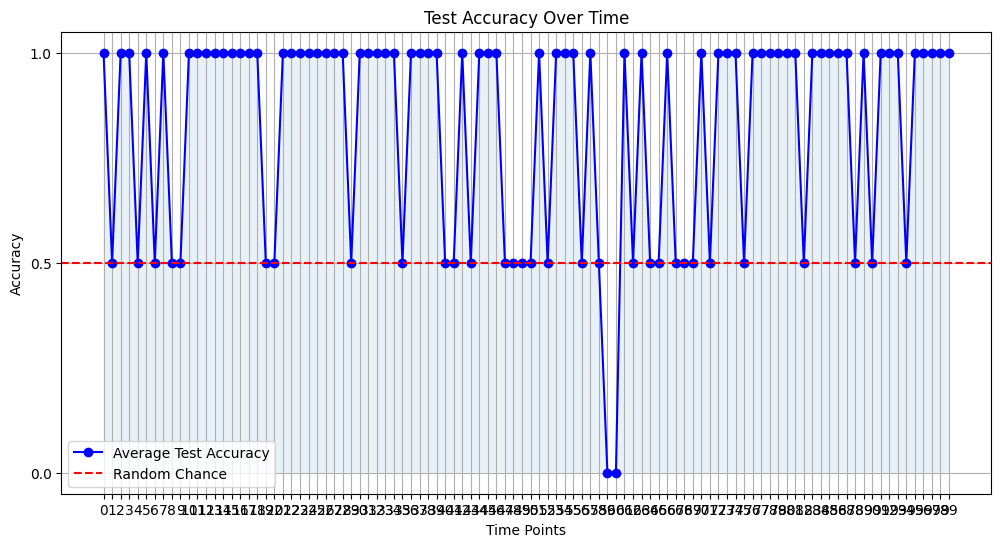

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample test accuracy data
test_accuracy = [
    [1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1],
    [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1],
    # Add the remaining arrays here...
]

# Convert test accuracy to a numpy array for easier manipulation
test_accuracy_np = np.array(test_accuracy)

# Average accuracy over the runs
average_accuracy = test_accuracy_np.mean(axis=0)

# Time points (assuming each inner list represents a time step)
time_points = np.arange(len(average_accuracy))

# Create the plot
plt.figure(figsize=(12, 6))
plt.plot(time_points, average_accuracy, marker='o', linestyle='-', color='b', label='Average Test Accuracy')
plt.fill_between(time_points, average_accuracy, alpha=0.1)
plt.title('Test Accuracy Over Time')
plt.xlabel('Time Points')
plt.ylabel('Accuracy')
plt.xticks(time_points)
plt.yticks([0, 0.5, 1])
plt.grid(True)
plt.axhline(y=0.5, color='r', linestyle='--', label='Random Chance')
plt.legend()
plt.show()


<Figure size 800x600 with 0 Axes>

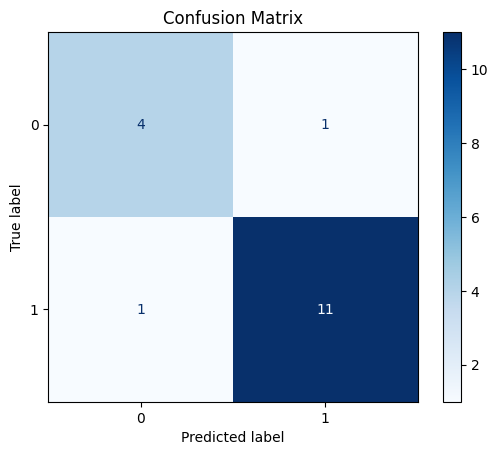

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Example true and predicted labels
# Here, replace these with your actual labels
true_labels = np.array([1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1])
predicted_labels = np.array([1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1])

# Create a confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Create a confusion matrix display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()
